### Projeto Final 
**Grupo:**
- Adriano Felipe Cabral Filho (afcf)
- Felipe Rodrigues de Souza (frs3)
- Lucas Vinícius José da Silva (lvjs)
- Pedro José Carneiro de Souza (pjcs) 
- Vitor Sousa Silva (vss2)


In [1]:
import time
import optuna
import numpy as np
import pandas as pd
from numpy import std
from numpy import mean
import scikitplot as skplt
import matplotlib.pyplot as plt

from random import randint
from tensorflow import keras 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, plot_confusion_matrix

ds = pd.read_csv('TRNcod.xls', delimiter = "\t")

# Shuffle no dataset
ds = ds.sample(frac=1).reset_index(drop=True)

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def compute_performance_metrics_sem_plot(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        # skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        # plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [ ]:
# print([d for d in ds.columns])

#### Tratamento do Dataset

In [2]:
# inadimplentes = pd.DataFrame(list(filter(lambda x: x == 1, ds['IND_BOM_1_2'])))

# Selecionando quem é inadimplente
inadimplentes = ds[ds['IND_BOM_1_2'] == 1]

# Selecionando quem é adimplente
adimplente = ds[ds['IND_BOM_1_2'] == 0]

global treino_ina
global teste_ina
global valid_ina
global treino_adi
global teste_adi
global valid_adi


# Dividindo datasets
treino_ina = inadimplentes[:int(len(inadimplentes)/2)]
teste_ina  = inadimplentes[int(len(inadimplentes)/2):int((len(inadimplentes)*3)/4)]
valid_ina  = inadimplentes[int((len(inadimplentes)*3)/4):]

treino_adi = adimplente[:int(len(adimplente)/2)]
teste_adi  = adimplente[int(len(adimplente)/2):int((len(adimplente)*3)/4)]
valid_adi  = adimplente[int((len(adimplente)*3)/4):]

# Equalizando tamanho de datasets treino e validação dos inadimplentes ao de adimplentes
treino_ina = treino_ina.loc[treino_ina.index.repeat(2)].drop('INDEX', axis=1)
treino_ina["COPIA"] = treino_ina.duplicated()
treino_ina.sort_values(by="COPIA", inplace=True, ignore_index=True)
treino_ina = treino_ina.iloc[ : ( len(treino_adi) - len(treino_ina) ), :  ]
treino_ina.drop(columns=["COPIA"], axis=1, inplace=True)

treino_adi.drop(columns=['INDEX'], axis=1, inplace=True)

valid_ina  = valid_ina.loc[valid_ina.index.repeat(2)].drop('INDEX', axis=1)
valid_ina["COPIA"] = valid_ina.duplicated()
valid_ina.sort_values(by="COPIA", inplace=True, ignore_index=True)
valid_ina = valid_ina.iloc[ : ( len(valid_adi) - len(valid_ina) ), :  ]
valid_ina.drop(columns=["COPIA"], axis=1, inplace=True)
# Fim da equalização

print('Tamanhos de inadimplentes: \nTreino: {}\nTeste: {}\nValidação: {}\n'.format(len(treino_ina.values), len(teste_ina.values), len(valid_ina.values)))
print('Tamanhos de adimplentes: \nTreino: {}\nTeste: {}\nValidação: {}\n'.format(len(treino_adi.values), len(teste_adi.values), len(valid_adi.values)))
print('Colunas: {}'.format(len([d for d in ds.columns])))
ds.drop(labels="INDEX", axis=1, inplace=True)

/home/vitor/.local/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Tamanhos de inadimplentes: 
Treino: 127549
Teste: 33524
Validação: 63775

Tamanhos de adimplentes: 
Treino: 127549
Teste: 63774
Validação: 63775

Colunas: 246


In [3]:
# https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
# https://psicometriaonline.com.br/como-testar-a-normalidade-da-amostra-com-kolgomorov-smirnov-e-shapiro-wilk/

# # Create correlation matrix
# corr_matrix = ds.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find features with correlation greater than 0.89
# to_drop = [column for column in upper.columns if any(upper[column] > 0.89)]

# # Drop features 
# # ds.drop(to_drop, axis=1, inplace=True)
# ds.columns


# Colunas mais correlacionadas
# l = []
# for c in ds.columns[:-1]:
#     l.append({c: ds[c].corr(ds['IND_BOM_1_1'])})
#     # if (ds[c].corr(ds['IND_BOM_1_1']) > 0.0):
#         # print( c, ds[c].corr(ds['IND_BOM_1_1']) )
# l.sort(key=lambda x: list(x.values())[0])
# print(l)

In [9]:
# Passos a fazer
# Esquema de experimentação (passo a passo do que vamos testar)
# MLP & Random Forest

### MLP

In [4]:
# https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow import keras

# MLP
model = Sequential()

# Dropout
layer = Dropout(randint(0,100)/100)

# Regularização
# ???

ds_2 = ds
# ds_2 = ds.iloc[ 0:300, : ]

trY = ds_2['IND_BOM_1_2']
trX = ds_2.drop('IND_BOM_1_2', axis=1)
trX = trX.drop('IND_BOM_1_1', axis=1)
# trX = trX.drop(columns=['INDEX'], axis=1)

# Taxa de parada quando não mais evoluir

model.add(Dense(32,input_dim=243, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

# Parada antecipada caso em 10 epochs ela deixe de melhorar
paradinha = EarlyStopping(monitor='accuracy', mode='max', patience=10)

history = model.fit(trX, trY, epochs=10000, verbose=1, callbacks=[paradinha])

Epoch 1/10000
12163/12163 [==============================] - 9s 593us/step - loss: 0.6022 - accuracy: 0.6707
Epoch 2/10000
12163/12163 [==============================] - 7s 577us/step - loss: 0.5943 - accuracy: 0.6772
Epoch 3/10000
12163/12163 [==============================] - 7s 572us/step - loss: 0.5921 - accuracy: 0.6796
Epoch 4/10000
12163/12163 [==============================] - 7s 574us/step - loss: 0.5909 - accuracy: 0.6807
Epoch 5/10000
12163/12163 [==============================] - 7s 590us/step - loss: 0.5901 - accuracy: 0.6815
Epoch 6/10000
12163/12163 [==============================] - 7s 594us/step - loss: 0.5893 - accuracy: 0.6822
Epoch 7/10000
12163/12163 [==============================] - 8s 641us/step - loss: 0.5888 - accuracy: 0.6823
Epoch 8/10000
12163/12163 [==============================] - 7s 607us/step - loss: 0.5883 - accuracy: 0.6829
Epoch 9/10000
12163/12163 [==============================] - 7s 554us/step - loss: 0.5881 - accuracy: 0.6827
Epoch 10/10000
1216

#### Resultados do MLP

In [6]:
def mlp_model(neuronios, camadas, dropout, learning_rate, ativacao, otimizador):
    model = Sequential()
    model.add(Dense(neuronios,input_dim=243, activation=ativacao))
    model.add(Dropout(dropout))
    if camadas==2:
        model.add(Dense(1, activation='sigmoid'))
    if otimizador =='adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif otimizador =='SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif otimizador =='RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif otimizador =='Adadelta':
        opt = keras.optimizers.Adadelta(learning_rate=learning_rate)
        
    
    model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=opt)
    return model

n_neuronios = [8, 16, 32, 64, 128, 512, 1024]
n_camadas = [1, 2]
n_dropout = [0.4, 0.2, 0.1]
n_learning_rate = [0.1, 0.01, 0.001]
n_ativacao = ['tanh', 'relu']
n_otimizador = ['adam', 'SGD', 'RMSprop','Adadelta']

# ds_2 = ds
ds_2 = ds.iloc[ 0:10000, : ]

trY = ds_2['IND_BOM_1_2']
trX = ds_2.drop('IND_BOM_1_2', axis=1)
trX = trX.drop('IND_BOM_1_1', axis=1)
# trX = trX.drop('INDEX', axis=1)


model = mlp_model(32, 2, 0.1, 0.0005,'relu','adam')

paradinha = EarlyStopping(monitor='accuracy', mode='max', patience=10)
history = model.fit(trX, trY, epochs=10000, verbose=1, callbacks=[paradinha])



Epoch 1/10000
313/313 [==============================] - 1s 595us/step - loss: 0.6398 - accuracy: 0.6446
Epoch 2/10000
313/313 [==============================] - 0s 664us/step - loss: 0.6197 - accuracy: 0.6564
Epoch 3/10000
313/313 [==============================] - 0s 650us/step - loss: 0.6125 - accuracy: 0.6602
Epoch 4/10000
313/313 [==============================] - 0s 641us/step - loss: 0.6058 - accuracy: 0.6694
Epoch 5/10000
313/313 [==============================] - 0s 732us/step - loss: 0.6016 - accuracy: 0.6727
Epoch 6/10000
313/313 [==============================] - 0s 766us/step - loss: 0.5974 - accuracy: 0.6789
Epoch 7/10000
313/313 [==============================] - 0s 613us/step - loss: 0.5935 - accuracy: 0.6800
Epoch 8/10000
313/313 [==============================] - 0s 860us/step - loss: 0.5882 - accuracy: 0.6809
Epoch 9/10000
313/313 [==============================] - 0s 666us/step - loss: 0.5878 - accuracy: 0.6817
Epoch 10/10000
313/313 [==============================]

#### Comentários acerca dos resultados do MLP

In [12]:
ds_3 = ds.iloc[ 50001:100001, :]
trY = ds_3['IND_BOM_1_2']
trX = ds_3.drop('IND_BOM_1_2', axis=1)
x, y = model.evaluate(trX, trY, verbose=1)

1563/1563 [==============================] - 1s 626us/step - loss: 5.3330 - accuracy: 0.6543


### Random Forest

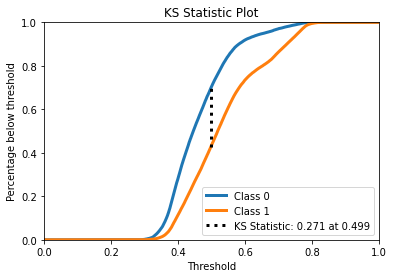

Acurácia: 0.6352097216777735
Recall: 0.5661152489219914
Precision: 0.6568902150576762
F1: 0.6081339430842955
AUROC: 0.6876080366943211
AURP: 0.6863975597334894


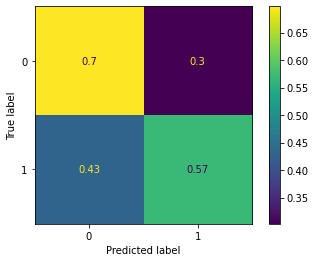

In [29]:
# Cuidado: usar esses parâmetros muito elevados, ou o default (100 estimadores e profundidade ilimitada) vai travar seu computador

# Parâmetros default:
# n_estimators=100, *,
# criterion="gini",
# max_depth=None,
# min_samples_split=2,
# min_samples_leaf=1,
# min_weight_fraction_leaf=0.,
# max_features="auto",
# max_leaf_nodes=None,
# min_impurity_decrease=0.,
# min_impurity_split=None,
# bootstrap=True,
# oob_score=False,
# n_jobs=None,
# random_state=None,
# verbose=0,
# warm_start=False,
# class_weight=None,
# ccp_alpha=0.0,
# max_samples=None

random_forest = RandomForestClassifier(n_estimators=128, max_depth=8, min_samples_leaf=2, min_samples_split=4, max_samples=randint(1,99)/100)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

random_forest.fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))

rf_pred_class  = random_forest.predict(df_validacao)
rf_pred_scores = random_forest.predict_proba(df_validacao)

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics([0]*len(valid_ina)+[1]*len(valid_adi), rf_pred_class, rf_pred_scores)
print('Acurácia: {}\nRecall: {}\nPrecision: {}\nF1: {}\nAUROC: {}\nAURP: {}'.format(accuracy, recall, precision, f1, auroc, aupr))

df_teste = teste_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(teste_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_teste.drop(columns=['INDEX'], axis=1, inplace=True)
plot_confusion_matrix(random_forest, df_teste, [0]*len(teste_ina)+[1]*len(teste_adi), normalize='true')

#### Teste de Kolmogorov-Smirnov (KS) e matriz de confusão da Random Forest
Acima, podemos ver os resultados de ambos. O teste de Kolmogorov-Smirnov assemelha-se bastante a uma distribuição normal. A matriz foi bem sucedida para identificar resultados falsos,  para casos verdadeiro seu resultado foi pouco acima de 50%.

In [ ]:
ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)


def rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 8, 32)
    max_depth = trial.suggest_int("max_depth", 16, 64)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 8)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 8)
    random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, bootstrap=True, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    print('Random Forest com {} estimadores e profundidade máxima {}, critério {}, min amostras de folhas {} e min divisão de amostras {}\n'.format(
        n_estimators, max_depth, criterion, min_samples_leaf, min_samples_split
    ))

    # start = time.time()
    # n_scores = cross_val_score(random_forest, ds_dropado, ds['IND_BOM_1_2'], scoring='accuracy', n_jobs=1, error_score='raise')
    # print('Acurácia e desvio padrão: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    # print("Tempo: ", format(time.time() - start, '.3f'), 's\n', sep='')

    random_forest.fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
    rf_pred_class  = random_forest.predict(df_validacao)
    rf_pred_scores = random_forest.predict_proba(df_validacao)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot([0]*len(valid_ina)+[1]*len(valid_adi), rf_pred_class, rf_pred_scores)
    # print('Acurácia: {} | Recall: {} | Precision: {} | F1: {} | AUROC: {} | AURP: {}\n'.format(accuracy, recall, precision, f1, auroc, aupr))
    return accuracy

study_1 = optuna.create_study(direction="maximize")
study_1.optimize(rf, n_trials=64)

#### Resultados da Random Forest

In [14]:
optuna.visualization.plot_optimization_history(study_1)

In [15]:
optuna.visualization.plot_slice(study_1)

In [16]:
optuna.visualization.plot_param_importances(study_1)

#### Comentários acerca dos resultados da Random Forest

A profundidade máxima é, sem dúvidas, o maior diferencial entre todos os hiperparâmetros; é possível perceber através do gráfico que quanto maior a profundidade melhor vai ser o desempenho, até atingir-se um limite. A quantidade de estimadores tem um impacto bastante menor, no gráfico, é possível ver que, excluindo-se os outliers, o número de estimadores realmente não interfere bastante no resultado final. A quantidade mínima de samples nas folhas tem impacto ainda menor, pode-se dizer que é inútil alterar este parâmetro.

### Gradient Boosting

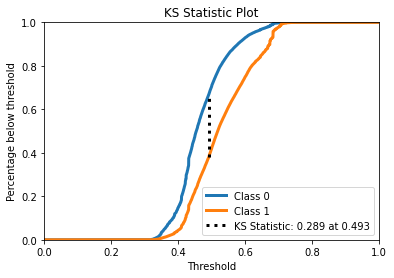

Acurácia: 0.6429086632693062
Recall: 0.5825950607604861
Precision: 0.6625120359473627
F1: 0.6199888200105125
AUROC: 0.6974324947088796
AURP: 0.6951357033971317




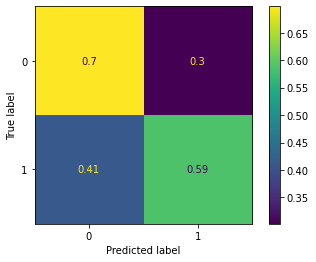

In [23]:
# Parâmetros default:
# *,loss='deviance', 
# learning_rate=0.1, 
# n_estimators=100,
# subsample=1.0, 
# criterion='friedman_mse', 
# min_samples_split=2,
# min_samples_leaf=1, 
# min_weight_fraction_leaf=0.,
# max_depth=3, 
# min_impurity_decrease=0.,
# min_impurity_split=None, 
# random_state=None, 
# max_features=None, verbose=0,
# max_leaf_nodes=None, 
# warm_start=False,
# validation_fraction=0.1, 
# n_iter_no_change=None, 
# tol=1e-4,
# ccp_alpha=0.0

ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

gradient_boost = GradientBoostingClassifier(n_estimators = 8, max_depth = 8, learning_rate=0.1)
gradient_boost.fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
gb_pred_class = gradient_boost.predict(df_validacao)
gb_pred_scores = gradient_boost.predict_proba(df_validacao)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics([0]*len(valid_ina)+[1]*len(valid_adi), gb_pred_class, gb_pred_scores)
print('Acurácia: {}\nRecall: {}\nPrecision: {}\nF1: {}\nAUROC: {}\nAURP: {}\n\n'.format(accuracy, recall, precision, f1, auroc, aupr))

df_teste = teste_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(teste_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_teste.drop(columns=['INDEX'], axis=1, inplace=True)
plot_confusion_matrix(gradient_boost, df_teste, [0]*len(teste_ina)+[1]*len(teste_adi), normalize='true')

#### Teste de Kolmogorov-Smirnov (KS) e matriz de confusão da Gradient Boosting
Acima, podemos ver os resultados de ambos. O teste de Kolmogorov-Smirnov assemelha-se, assim como a Random Forest, bastante a uma distribuição normal. Mais uma vez (semelhante a Random Forest), a matriz foi bem sucedida para identificar resultados falsos, para casos verdadeiro seu resultado foi pouco acima de 50%. Podemos afirmar que para apenas um teste, o Gradient Boosting se saiu melhor.

In [7]:
ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

def gb(trial):
    n_estimators = trial.suggest_int("n_estimators", 8, 32)
    max_depth = trial.suggest_int("max_depth", 16, 64)
    loss = trial.suggest_categorical("loss", ["deviance", "exponential"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.7)
    subsample = trial.suggest_float("subsample", 0.01, 0.7)
    print('Gradient Boosting com {} estimadores e profundidade máxima {}, critério {}, min amostras de folhas {}, subsample de {} e taxa de aprendizagem {}\n'.format(
        n_estimators, max_depth, loss, min_samples_leaf, subsample, learning_rate
    ))

    gradient_boost = GradientBoostingClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf, learning_rate = learning_rate, loss = loss, subsample = subsample)
    gradient_boost.fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
    gb_pred_class = gradient_boost.predict(df_validacao)
    gb_pred_scores = gradient_boost.predict_proba(df_validacao)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot([0]*len(valid_ina)+[1]*len(valid_adi), gb_pred_class, gb_pred_scores)
    # print('Acurácia: {} | Recall: {} | Precision: {} | F1: {} | AUROC: {} | AURP: {}\n'.format(accuracy, recall, precision, f1, auroc, aupr))
    return accuracy

study_2 = optuna.create_study(direction="maximize")
study_2.optimize(gb, n_trials=32)

[I 2021-12-02 20:02:50,172] A new study created in memory with name: no-name-9600e191-407b-427e-8142-e50f6c2dfd04


Gradient Boosting com 24 estimadores e profundidade máxima 48, critério exponential, min amostras de folhas 2, subsample de 0.23771973606148233 e taxa de aprendizagem 0.44519528481328524



[I 2021-12-02 20:12:51,657] Trial 0 finished with value: 0.5801332810662485 and parameters: {'n_estimators': 24, 'max_depth': 48, 'loss': 'exponential', 'min_samples_leaf': 2, 'learning_rate': 0.44519528481328524, 'subsample': 0.23771973606148233}. Best is trial 0 with value: 0.5801332810662485.


Gradient Boosting com 13 estimadores e profundidade máxima 31, critério deviance, min amostras de folhas 2, subsample de 0.6749218534197728 e taxa de aprendizagem 0.6852483228210666



[I 2021-12-02 20:25:52,107] Trial 1 finished with value: 0.5829086632693061 and parameters: {'n_estimators': 13, 'max_depth': 31, 'loss': 'deviance', 'min_samples_leaf': 2, 'learning_rate': 0.6852483228210666, 'subsample': 0.6749218534197728}. Best is trial 1 with value: 0.5829086632693061.


Gradient Boosting com 32 estimadores e profundidade máxima 21, critério exponential, min amostras de folhas 8, subsample de 0.15902631670582318 e taxa de aprendizagem 0.2674847983743691



[I 2021-12-02 20:30:58,528] Trial 2 finished with value: 0.5929674637397099 and parameters: {'n_estimators': 32, 'max_depth': 21, 'loss': 'exponential', 'min_samples_leaf': 8, 'learning_rate': 0.2674847983743691, 'subsample': 0.15902631670582318}. Best is trial 2 with value: 0.5929674637397099.


Gradient Boosting com 16 estimadores e profundidade máxima 33, critério deviance, min amostras de folhas 6, subsample de 0.42799899445475914 e taxa de aprendizagem 0.6084992601216576



[I 2021-12-02 20:40:09,678] Trial 3 finished with value: 0.5708349666797334 and parameters: {'n_estimators': 16, 'max_depth': 33, 'loss': 'deviance', 'min_samples_leaf': 6, 'learning_rate': 0.6084992601216576, 'subsample': 0.42799899445475914}. Best is trial 2 with value: 0.5929674637397099.


Gradient Boosting com 27 estimadores e profundidade máxima 51, critério deviance, min amostras de folhas 7, subsample de 0.5277830879530203 e taxa de aprendizagem 0.34066523569840884



[I 2021-12-02 20:59:20,237] Trial 4 finished with value: 0.5929596236769894 and parameters: {'n_estimators': 27, 'max_depth': 51, 'loss': 'deviance', 'min_samples_leaf': 7, 'learning_rate': 0.34066523569840884, 'subsample': 0.5277830879530203}. Best is trial 2 with value: 0.5929674637397099.


Gradient Boosting com 12 estimadores e profundidade máxima 51, critério deviance, min amostras de folhas 3, subsample de 0.6565612605360166 e taxa de aprendizagem 0.03508025987144762



[I 2021-12-02 21:07:16,192] Trial 5 finished with value: 0.6026577812622501 and parameters: {'n_estimators': 12, 'max_depth': 51, 'loss': 'deviance', 'min_samples_leaf': 3, 'learning_rate': 0.03508025987144762, 'subsample': 0.6565612605360166}. Best is trial 5 with value: 0.6026577812622501.


Gradient Boosting com 32 estimadores e profundidade máxima 43, critério deviance, min amostras de folhas 7, subsample de 0.09234425376365585 e taxa de aprendizagem 0.34379196846200294



[I 2021-12-02 21:09:38,261] Trial 6 finished with value: 0.5431438651509212 and parameters: {'n_estimators': 32, 'max_depth': 43, 'loss': 'deviance', 'min_samples_leaf': 7, 'learning_rate': 0.34379196846200294, 'subsample': 0.09234425376365585}. Best is trial 5 with value: 0.6026577812622501.


Gradient Boosting com 31 estimadores e profundidade máxima 60, critério exponential, min amostras de folhas 7, subsample de 0.5176126193776753 e taxa de aprendizagem 0.6911843790599667



[I 2021-12-02 21:37:17,215] Trial 7 finished with value: 0.5745433163465308 and parameters: {'n_estimators': 31, 'max_depth': 60, 'loss': 'exponential', 'min_samples_leaf': 7, 'learning_rate': 0.6911843790599667, 'subsample': 0.5176126193776753}. Best is trial 5 with value: 0.6026577812622501.


Gradient Boosting com 15 estimadores e profundidade máxima 48, critério exponential, min amostras de folhas 6, subsample de 0.11649092564448998 e taxa de aprendizagem 0.2753781184736413



[I 2021-12-02 21:38:50,194] Trial 8 finished with value: 0.5873304586436692 and parameters: {'n_estimators': 15, 'max_depth': 48, 'loss': 'exponential', 'min_samples_leaf': 6, 'learning_rate': 0.2753781184736413, 'subsample': 0.11649092564448998}. Best is trial 5 with value: 0.6026577812622501.


Gradient Boosting com 14 estimadores e profundidade máxima 57, critério deviance, min amostras de folhas 4, subsample de 0.2444855767196958 e taxa de aprendizagem 0.47465292063376036



[I 2021-12-02 21:42:41,710] Trial 9 finished with value: 0.561983535868287 and parameters: {'n_estimators': 14, 'max_depth': 57, 'loss': 'deviance', 'min_samples_leaf': 4, 'learning_rate': 0.47465292063376036, 'subsample': 0.2444855767196958}. Best is trial 5 with value: 0.6026577812622501.


Gradient Boosting com 8 estimadores e profundidade máxima 63, critério deviance, min amostras de folhas 4, subsample de 0.6661412213292512 e taxa de aprendizagem 0.01316383613075282



[I 2021-12-02 21:47:32,100] Trial 10 finished with value: 0.5980713445707566 and parameters: {'n_estimators': 8, 'max_depth': 63, 'loss': 'deviance', 'min_samples_leaf': 4, 'learning_rate': 0.01316383613075282, 'subsample': 0.6661412213292512}. Best is trial 5 with value: 0.6026577812622501.


Gradient Boosting com 8 estimadores e profundidade máxima 64, critério deviance, min amostras de folhas 4, subsample de 0.6909831505879832 e taxa de aprendizagem 0.022046201526297243



[I 2021-12-02 21:52:34,597] Trial 11 finished with value: 0.6006585652685221 and parameters: {'n_estimators': 8, 'max_depth': 64, 'loss': 'deviance', 'min_samples_leaf': 4, 'learning_rate': 0.022046201526297243, 'subsample': 0.6909831505879832}. Best is trial 5 with value: 0.6026577812622501.


Gradient Boosting com 8 estimadores e profundidade máxima 63, critério deviance, min amostras de folhas 3, subsample de 0.680766154110132 e taxa de aprendizagem 0.01951852407708382



[I 2021-12-02 21:58:03,305] Trial 12 finished with value: 0.5958290866326931 and parameters: {'n_estimators': 8, 'max_depth': 63, 'loss': 'deviance', 'min_samples_leaf': 3, 'learning_rate': 0.01951852407708382, 'subsample': 0.680766154110132}. Best is trial 5 with value: 0.6026577812622501.


Gradient Boosting com 10 estimadores e profundidade máxima 54, critério deviance, min amostras de folhas 4, subsample de 0.5695886318316041 e taxa de aprendizagem 0.12681777933896174



[I 2021-12-02 22:03:14,474] Trial 13 finished with value: 0.599874558996472 and parameters: {'n_estimators': 10, 'max_depth': 54, 'loss': 'deviance', 'min_samples_leaf': 4, 'learning_rate': 0.12681777933896174, 'subsample': 0.5695886318316041}. Best is trial 5 with value: 0.6026577812622501.


Gradient Boosting com 19 estimadores e profundidade máxima 39, critério deviance, min amostras de folhas 3, subsample de 0.3917498021073445 e taxa de aprendizagem 0.12967870964222739



[I 2021-12-02 22:10:42,202] Trial 14 finished with value: 0.6049470795766366 and parameters: {'n_estimators': 19, 'max_depth': 39, 'loss': 'deviance', 'min_samples_leaf': 3, 'learning_rate': 0.12967870964222739, 'subsample': 0.3917498021073445}. Best is trial 14 with value: 0.6049470795766366.


Gradient Boosting com 20 estimadores e profundidade máxima 36, critério deviance, min amostras de folhas 3, subsample de 0.3898953433564848 e taxa de aprendizagem 0.15379694507109726



[I 2021-12-02 22:18:41,717] Trial 15 finished with value: 0.6041160329282634 and parameters: {'n_estimators': 20, 'max_depth': 36, 'loss': 'deviance', 'min_samples_leaf': 3, 'learning_rate': 0.15379694507109726, 'subsample': 0.3898953433564848}. Best is trial 14 with value: 0.6049470795766366.


Gradient Boosting com 20 estimadores e profundidade máxima 33, critério deviance, min amostras de folhas 3, subsample de 0.34777024806644213 e taxa de aprendizagem 0.13901983217045266



[I 2021-12-02 22:25:44,232] Trial 16 finished with value: 0.6006507252058016 and parameters: {'n_estimators': 20, 'max_depth': 33, 'loss': 'deviance', 'min_samples_leaf': 3, 'learning_rate': 0.13901983217045266, 'subsample': 0.34777024806644213}. Best is trial 14 with value: 0.6049470795766366.


Gradient Boosting com 19 estimadores e profundidade máxima 25, critério deviance, min amostras de folhas 2, subsample de 0.3719721155989819 e taxa de aprendizagem 0.18664302220651185



[I 2021-12-02 22:32:03,257] Trial 17 finished with value: 0.6020854566836534 and parameters: {'n_estimators': 19, 'max_depth': 25, 'loss': 'deviance', 'min_samples_leaf': 2, 'learning_rate': 0.18664302220651185, 'subsample': 0.3719721155989819}. Best is trial 14 with value: 0.6049470795766366.


Gradient Boosting com 22 estimadores e profundidade máxima 40, critério deviance, min amostras de folhas 5, subsample de 0.42396967159885013 e taxa de aprendizagem 0.10670256525220301



[I 2021-12-02 22:40:28,702] Trial 18 finished with value: 0.608890631125049 and parameters: {'n_estimators': 22, 'max_depth': 40, 'loss': 'deviance', 'min_samples_leaf': 5, 'learning_rate': 0.10670256525220301, 'subsample': 0.42396967159885013}. Best is trial 18 with value: 0.608890631125049.


Gradient Boosting com 24 estimadores e profundidade máxima 41, critério deviance, min amostras de folhas 5, subsample de 0.4643020668018045 e taxa de aprendizagem 0.25517394934518467



[I 2021-12-02 22:52:44,534] Trial 19 finished with value: 0.5936730693845551 and parameters: {'n_estimators': 24, 'max_depth': 41, 'loss': 'deviance', 'min_samples_leaf': 5, 'learning_rate': 0.25517394934518467, 'subsample': 0.4643020668018045}. Best is trial 18 with value: 0.608890631125049.


Gradient Boosting com 23 estimadores e profundidade máxima 26, critério deviance, min amostras de folhas 5, subsample de 0.30377939745101523 e taxa de aprendizagem 0.06838482666178361



[I 2021-12-02 22:57:14,379] Trial 20 finished with value: 0.6138063504508036 and parameters: {'n_estimators': 23, 'max_depth': 26, 'loss': 'deviance', 'min_samples_leaf': 5, 'learning_rate': 0.06838482666178361, 'subsample': 0.30377939745101523}. Best is trial 20 with value: 0.6138063504508036.


Gradient Boosting com 23 estimadores e profundidade máxima 27, critério deviance, min amostras de folhas 5, subsample de 0.292956290187775 e taxa de aprendizagem 0.09649951610190696



[I 2021-12-02 23:01:37,727] Trial 21 finished with value: 0.6103802430419444 and parameters: {'n_estimators': 23, 'max_depth': 27, 'loss': 'deviance', 'min_samples_leaf': 5, 'learning_rate': 0.09649951610190696, 'subsample': 0.292956290187775}. Best is trial 20 with value: 0.6138063504508036.


Gradient Boosting com 24 estimadores e profundidade máxima 26, critério deviance, min amostras de folhas 5, subsample de 0.26871392830157187 e taxa de aprendizagem 0.08728752024805701



[I 2021-12-02 23:05:45,254] Trial 22 finished with value: 0.611344570756566 and parameters: {'n_estimators': 24, 'max_depth': 26, 'loss': 'deviance', 'min_samples_leaf': 5, 'learning_rate': 0.08728752024805701, 'subsample': 0.26871392830157187}. Best is trial 20 with value: 0.6138063504508036.


Gradient Boosting com 28 estimadores e profundidade máxima 17, critério deviance, min amostras de folhas 6, subsample de 0.30197312427287565 e taxa de aprendizagem 0.07932588941052122



[I 2021-12-02 23:10:04,390] Trial 23 finished with value: 0.6237475499803998 and parameters: {'n_estimators': 28, 'max_depth': 17, 'loss': 'deviance', 'min_samples_leaf': 6, 'learning_rate': 0.07932588941052122, 'subsample': 0.30197312427287565}. Best is trial 23 with value: 0.6237475499803998.


Gradient Boosting com 27 estimadores e profundidade máxima 16, critério deviance, min amostras de folhas 6, subsample de 0.02745577255055387 e taxa de aprendizagem 0.20804359903889136



[I 2021-12-02 23:10:26,639] Trial 24 finished with value: 0.5674480595844766 and parameters: {'n_estimators': 27, 'max_depth': 16, 'loss': 'deviance', 'min_samples_leaf': 6, 'learning_rate': 0.20804359903889136, 'subsample': 0.02745577255055387}. Best is trial 23 with value: 0.6237475499803998.


Gradient Boosting com 28 estimadores e profundidade máxima 16, critério deviance, min amostras de folhas 6, subsample de 0.2891701982469094 e taxa de aprendizagem 0.08596498390275462



[I 2021-12-02 23:14:24,394] Trial 25 finished with value: 0.6297216777734221 and parameters: {'n_estimators': 28, 'max_depth': 16, 'loss': 'deviance', 'min_samples_leaf': 6, 'learning_rate': 0.08596498390275462, 'subsample': 0.2891701982469094}. Best is trial 25 with value: 0.6297216777734221.


Gradient Boosting com 28 estimadores e profundidade máxima 16, critério deviance, min amostras de folhas 6, subsample de 0.18914638329141092 e taxa de aprendizagem 0.06228081479140194



[I 2021-12-02 23:16:59,932] Trial 26 finished with value: 0.6284202273618189 and parameters: {'n_estimators': 28, 'max_depth': 16, 'loss': 'deviance', 'min_samples_leaf': 6, 'learning_rate': 0.06228081479140194, 'subsample': 0.18914638329141092}. Best is trial 25 with value: 0.6297216777734221.


Gradient Boosting com 29 estimadores e profundidade máxima 16, critério exponential, min amostras de folhas 8, subsample de 0.19024152360354002 e taxa de aprendizagem 0.2018127443157223



[I 2021-12-02 23:19:40,418] Trial 27 finished with value: 0.6087573500588005 and parameters: {'n_estimators': 29, 'max_depth': 16, 'loss': 'exponential', 'min_samples_leaf': 8, 'learning_rate': 0.2018127443157223, 'subsample': 0.19024152360354002}. Best is trial 25 with value: 0.6297216777734221.


Gradient Boosting com 29 estimadores e profundidade máxima 20, critério deviance, min amostras de folhas 6, subsample de 0.19891665528270594 e taxa de aprendizagem 0.050645586197333115



[I 2021-12-02 23:22:51,887] Trial 28 finished with value: 0.6263190905527244 and parameters: {'n_estimators': 29, 'max_depth': 20, 'loss': 'deviance', 'min_samples_leaf': 6, 'learning_rate': 0.050645586197333115, 'subsample': 0.19891665528270594}. Best is trial 25 with value: 0.6297216777734221.


Gradient Boosting com 30 estimadores e profundidade máxima 21, critério exponential, min amostras de folhas 7, subsample de 0.20055934354730437 e taxa de aprendizagem 0.4815556863074403



[I 2021-12-02 23:26:34,450] Trial 29 finished with value: 0.5744884359074872 and parameters: {'n_estimators': 30, 'max_depth': 21, 'loss': 'exponential', 'min_samples_leaf': 7, 'learning_rate': 0.4815556863074403, 'subsample': 0.20055934354730437}. Best is trial 25 with value: 0.6297216777734221.


Gradient Boosting com 26 estimadores e profundidade máxima 22, critério deviance, min amostras de folhas 6, subsample de 0.025385407194004728 e taxa de aprendizagem 0.4088263316634886



[I 2021-12-02 23:26:55,900] Trial 30 finished with value: 0.5290395923167386 and parameters: {'n_estimators': 26, 'max_depth': 22, 'loss': 'deviance', 'min_samples_leaf': 6, 'learning_rate': 0.4088263316634886, 'subsample': 0.025385407194004728}. Best is trial 25 with value: 0.6297216777734221.


Gradient Boosting com 28 estimadores e profundidade máxima 16, critério deviance, min amostras de folhas 6, subsample de 0.22126621383926443 e taxa de aprendizagem 0.06259004439137035



[I 2021-12-02 23:29:57,434] Trial 31 finished with value: 0.6301293610348883 and parameters: {'n_estimators': 28, 'max_depth': 16, 'loss': 'deviance', 'min_samples_leaf': 6, 'learning_rate': 0.06259004439137035, 'subsample': 0.22126621383926443}. Best is trial 31 with value: 0.6301293610348883.


#### Resultados do Gradient Boosting

In [8]:
optuna.visualization.plot_optimization_history(study_2)

In [9]:
optuna.visualization.plot_slice(study_2)

In [10]:
optuna.visualization.plot_param_importances(study_2)

#### Comentários acerca dos resultados do Gredient Boosting

### Regressão Logística

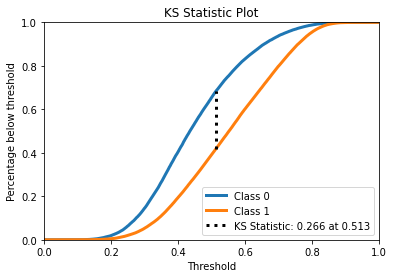

Acurácia: 0.6317600940807526
Recall: 0.6096275970207762
Precision: 0.6378625803911274
F1: 0.6234255614261547
AUROC: 0.6789376268151658
AURP: 0.6677653788880806




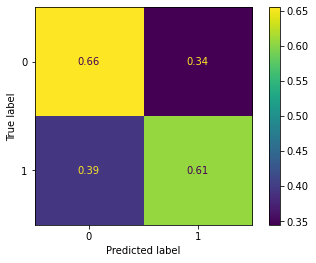

In [16]:
# Parâmetros default
# penalty='l2', 
# *, 
# dual=False, 
# tol=1e-4, 
# C=1.0,
# fit_intercept=True, 
# intercept_scaling=1, 
# class_weight=None,
# random_state=None, 
# solver='lbfgs', 
# max_iter=100,
# multi_class='auto', 
# verbose=0, 
# warm_start=False, 
# n_jobs=None,
# l1_ratio=None

ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

regressao_log = LogisticRegression(max_iter=1000).fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
rl_pred_class = regressao_log.predict(df_validacao)
rl_pred_scores = regressao_log.predict_proba(df_validacao)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics([0]*len(valid_ina)+[1]*len(valid_adi), rl_pred_class, rl_pred_scores)
print('Acurácia: {}\nRecall: {}\nPrecision: {}\nF1: {}\nAUROC: {}\nAURP: {}\n\n'.format(accuracy, recall, precision, f1, auroc, aupr))
df_teste = teste_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(teste_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_teste.drop(columns=['INDEX'], axis=1, inplace=True)
plot_confusion_matrix(regressao_log, df_teste, [0]*len(teste_ina)+[1]*len(teste_adi), normalize='true')

#### Teste de Kolmogorov-Smirnov (KS) e matriz de confusão da Regressão Logística
Acima, podemos ver os resultados de ambos. O teste de Kolmogorov-Smirnov assemelha-se, assim como a Random Forest e Gradient Boosting, bastante a uma distribuição normal. Semelhante aos já supracitados, a matriz foi melhor sucedida para identificar resultados falsos, porém, os resultados caíram na identificação de resultados falsos mas foram os melhores até então para identificar resultados verdadeiros.

In [ ]:
ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

def rl(trial):
    # penalty = trial.suggest_categorical("penalty", ["none", "l2", "l1", "elasticnet"])
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])
    C = trial.suggest_float("C", 0.01, 1.0)
    multi_class = "ovr"
    print('Regressão Logística com solver {} e C {}\n'.format(
        solver, C
    ))

    regressao_log = LogisticRegression(max_iter=1000, solver=solver, C=C, multi_class=multi_class).fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
    regressao_log.fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
    rl_pred_class = regressao_log.predict(df_validacao)
    rl_pred_scores = regressao_log.predict_proba(df_validacao)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot([0]*len(valid_ina)+[1]*len(valid_adi), rl_pred_class, rl_pred_scores)
    # print('Acurácia: {} | Recall: {} | Precision: {} | F1: {} | AUROC: {} | AURP: {}\n'.format(accuracy, recall, precision, f1, auroc, aupr))
    return accuracy

study_3 = optuna.create_study(direction="maximize")
study_3.optimize(rl, n_trials=64)

#### Resultados da Regressão Logística

In [ ]:
optuna.visualization.plot_optimization_history(study_3)

In [ ]:
optuna.visualization.plot_slice(study_3)

In [ ]:
optuna.visualization.plot_param_importances(study_3)

#### Comentários acerca dos resultados da Regressão Logística